# Demo: Gaussian processes under monotonicity constraints in 2D

In this notebook, we propose a demo example of the implementation of a Gaussian process (GP) under monotonicity constraints. The model is constructed via the MaxMod algorithm proposed in [1]

[1] F. Bachoc, A. F. López-Lopera, and O. Roustant (2020). *Sequential construction and dimension reduction of Gaussian
processes under inequality constraints*, SIAM Journal on Mathematics of Data Science, 4(2). URL: https://arxiv.org/abs/2009.04188.

In [1]:
# loading useful libraries
library("lineqGPR")
require("DiceDesign")
library("plot3D")
library("viridis")

rm(list=ls())
options(warn=-1)

Le chargement a nécessité le package : broom

Le chargement a nécessité le package : nloptr

Le chargement a nécessité le package : purrr

Le chargement a nécessité le package : DiceDesign

Le chargement a nécessité le package : viridisLite



In [2]:
# Synthetic data: monotonic function
targetFun <- function(x) return(atan(5*x[,2])  + 0.5*x[,1])

In [3]:
D <- 2 # number of active + inactive input variables
d <- 2 # number of active input variables

# building DoE in dimension D via Latin hypercube sampling (LHS)
nbPoints <- 40*D # nb of training data
xdesign <- lhsDesign(nbPoints, D, seed = 2)$design
xdesign <- maximinSA_LHS(xdesign)$design
xdesign <- xdesign[,2:1]
ydesign <- targetFun(xdesign)

# building a DoE for assessing the model
ntest <- 10*D
xtest <- matrix(seq(0, 1, length = ntest))
xtest <- as.matrix(expand.grid(xtest, xtest))
xtest <- xtest[,2:1]
ytest <- targetFun(xtest)

In [4]:
# initializing a 1D GP model with only two knots 
model <-  create(class = 'lineqGP',
                 x = xdesign, y = ydesign,
                 constrType = "monotonicity", m = 2)
model$kernParam$type <- "matern52"
model$varnoise <- var(ydesign)
model$kernParam$nugget <- 1e-5

In [5]:
# updating the model according to the MaxMod algorithm
max_iter <- 10
tol <- 1e-5
model <- MaxMod(model,
                xtest,
                tol = tol,
                max_iter = max_iter,
                reward_new_knot = 1e-9,
                reward_new_dim = 1e-12,
                print_iter = TRUE,
                nClusters = 1,
                save_history = TRUE)

message("\nNumber of active dimensions: ", d)
message("Number of actived dimensions via MaxMod: ", model$d, "\n")

                     dim 1     dim 2
MaxMod criterion 0.8442379 0.8847062
knot's position        NaN       NaN
decision         0.0000000 1.0000000


Iter 1 - dimension 2 added as d = 1 (Relative MaxMod criterion = Inf)



                       dim 1      dim 2
MaxMod criterion 0.009802148 0.01886983
knot's position          NaN 0.40204860
decision         0.000000000 1.00000000


Iter 2 - New knot added: d = 1 (Relative MaxMod criterion = 0.0106644618646309)



                      dim 1       dim 2
MaxMod criterion 0.01090446 0.001456632
knot's position         NaN 0.236312959
decision         1.00000000 0.000000000


Iter 3 - dimension 1 added as d = 2 (Relative MaxMod criterion = 0.00627794518954239)



                        dim 1        dim 2
MaxMod criterion 2.005798e-05 0.0007221418
knot's position  3.985432e-01 0.2047034219
decision         0.000000e+00 1.0000000000


Iter 4 - New knot added: d = 1 (Relative MaxMod criterion = 0.000408925371042609)



                        dim 1        dim 2
MaxMod criterion 1.135893e-05 4.842424e-05
knot's position  7.974868e-01 6.275473e-01
decision         0.000000e+00 1.000000e+00


Iter 5 - New knot added: d = 1 (Relative MaxMod criterion = 2.72952789887695e-05)



                        dim 1        dim 2
MaxMod criterion 4.428698e-06 9.264300e-07
knot's position  4.489373e-01 3.789424e-01
decision         1.000000e+00 0.000000e+00


Iter 6 - New knot added: d = 2 (Relative MaxMod criterion = 2.46167759542169e-06)

The sequential algorithm converged


Number of active dimensions: 2

Number of actived dimensions via MaxMod: 2




In [6]:
# evaluating the model using an equispaced grid of points
ntest <- 10
xtestGrid  <- as.matrix(expand.grid(seq(0, 1, length = ntest), seq(0, 1, length = ntest)))
ytestGrid <- targetFun(xtestGrid)
pred <- predict(model, xtestGrid)

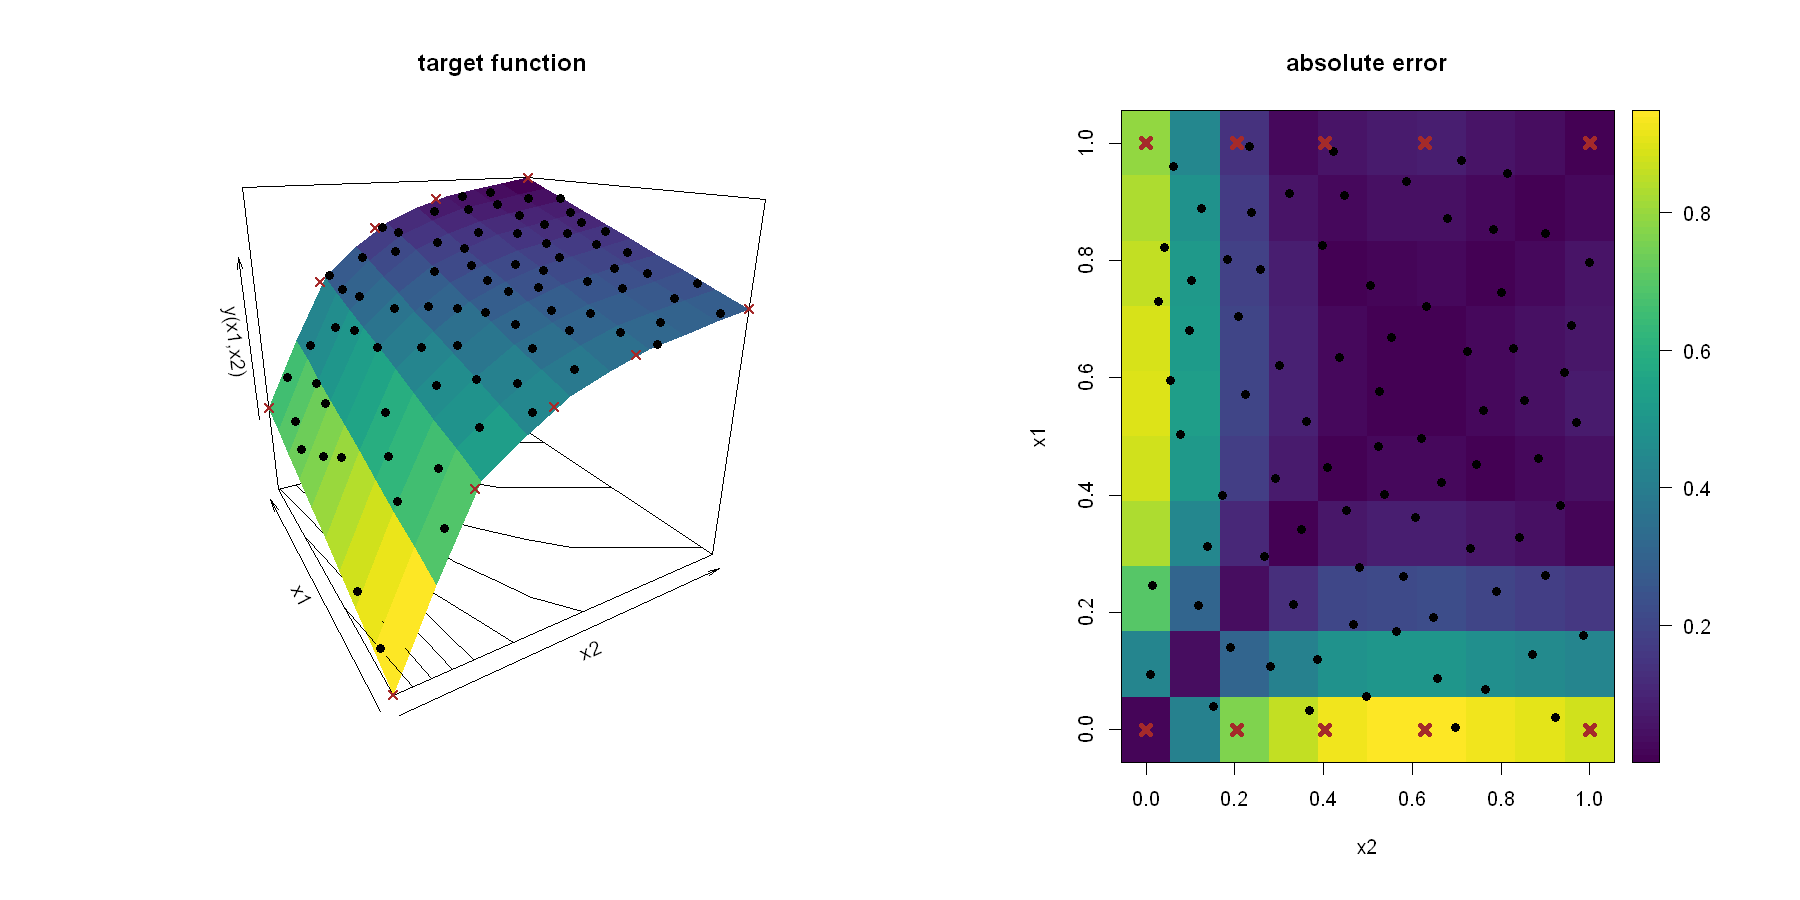

In [7]:
# plotting the MAP estimate
colormap <- rev(viridis(1e2))
par(mfrow = c(1,2))
options(repr.plot.width = 15, repr.plot.height = 7.5)
p <- persp3D(x = seq(0, 1, length = ntest), y = seq(0, 1, length = ntest),
             z = matrix(pred$Phi.test %*% pred$xi.map, nrow = ntest),
             xlab = "x2", ylab = "x1", zlab = "y(x1,x2)",
             main = "target function",
             phi = 20, theta = -30, col = colormap,
             contour = TRUE, colkey=FALSE)
points(trans3D(x = model$x[, 1], y = model$x[, 2], z = ydesign, pmat = p),
       col = 'black', pch = 19)
u <- expand.grid(model$ulist[[1]], model$ulist[[2]])
pred_Knots <- predict(model, as.matrix(u))
points(trans3D(x = u[, 1], y = u[, 2], z = pred_Knots$Phi.test %*% pred_Knots$xi.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)

diff = ytestGrid - pred$Phi.test %*% pred$xi.map
image2D(abs(matrix(diff, nrow = ntest)), col = rev(colormap),
        main = "absolute error", xlab = "x2", ylab = "x1")
points2D(model$x[, 1], model$x[, 2], add = TRUE, pch = 19, col ='black')
points2D(u[, 1], u[, 2], add = TRUE, pch = 4, lwd = 4, col ='brown')

